In [1]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

import numpy as np
import pylab

In [2]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

In [3]:
def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P

In [10]:
def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y

In [427]:
class TSNE:
    def __init__(self, X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
        
        if isinstance(no_dims, float):
            print("Error: array X should have type float.")
        if round(no_dims) != no_dims:
            print("Error: number of dimensions should be an integer.")


        # Initialize variables
        (self.no_dims, self.initial_dims, self.perplexity) = (no_dims, initial_dims, perplexity)
        self.X = X
        if X.shape[1] >=50:
            self.X = pca(X, initial_dims).real
        (self.n, self.d) = X.shape
        self.max_iter = 1000
        self.initial_momentum = 0.5
        self.final_momentum = 0.8
        self.eta = 500
        self.min_gain = 0.01
#         np.random.seed(seed=1)
        self.Y = np.random.randn(self.n, no_dims)
        self.dY = np.zeros((self.n, no_dims))
        self.iY = np.zeros((self.n, no_dims))
        self.gains = np.ones((self.n, no_dims))

        # Compute P-values
        P = x2p(self.X, 1e-5, self.perplexity)
        P = P + np.transpose(P)
        P = P / np.sum(P)
        P = P * 4.									# early exaggeration
        self.P = np.maximum(P, 1e-12)
        self.embeddings_before_mmd = []
        self.embeddings_after_mmd = []
        self.ce_loss = []
        self.mmd_loss = []
    
    def _update(self, iter):
        
        # Compute pairwise affinities
        sum_Y = np.sum(np.square(self.Y), 1)
        num = -2. * np.dot(self.Y, self.Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(self.n), range(self.n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = self.P - Q
        for i in range(self.n):
            self.dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (self.no_dims, 1)).T * (self.Y[i, :] - self.Y), 0)

        # Perform the update
        if iter < 20:
            momentum = self.initial_momentum
        else:
            momentum = self.final_momentum
        self.gains = (self.gains + 0.2) * ((self.dY > 0.) != (self.iY > 0.)) + \
                (self.gains * 0.8) * ((self.dY > 0.) == (self.iY > 0.))
        self.gains[self.gains < self.min_gain] = self.min_gain
        self.iY = momentum * self.iY - self.eta * (self.gains * self.dY)
        self.Y = self.Y + self.iY
        self.Y = self.Y - np.tile(np.mean(self.Y, 0), (self.n, 1))

        # Compute current value of cost function
        C = np.sum(self.P * np.log(self.P / Q))
        if (iter + 1) % 10 == 0:
#             C = np.sum(self.P * np.log(self.P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            self.P = self.P / 4.
            
        self.ce_loss.append(C)
        

In [192]:

from sklearn.metrics.pairwise import rbf_kernel as rbf


def mmd(embedding1, embedding2, proximity=0.1, ratio=1):
    ker1 = rbf(embedding1, embedding1, gamma=proximity)
    ker2 = rbf(embedding2, embedding2, gamma=proximity)
    ker12 = rbf(embedding1, embedding2, gamma=proximity)
    ker21 = ker12.T
    new_embedding1 = embedding1.copy()
    new_embedding2 = embedding2.copy()
    n = embedding1.shape[0]
    m = embedding2.shape[0]
    for i in range(embedding1.shape[0]):
        for j in range(embedding1.shape[1]):
            l = ratio * (2 / (n * n)) * np.dot(ker1[i], embedding1[i, j] - embedding1[:, j])
#             print("llllllll:", l)
#             print(new_embedding1[i, j])
            new_embedding1[i, j] += l
#             break
#         break

    for i in range(embedding2.shape[0]):
        for j in range(embedding2.shape[1]):
            l = ratio * (2 / (m * m)) * np.dot(ker2[i], embedding2[i, j] - embedding2[:, j])
#             print("llllllll:", l)
#             print(new_embedding2[i, j])
            new_embedding2[i, j] += l
#             break
#         break

    for i in range(embedding1.shape[0]):
        for j in range(embedding1.shape[1]):
            l = ratio * (4 / (n * m)) * np.dot(ker12[i], embedding1[i, j] - embedding2[:, j])
#             print("llllllll:", l)
#             print(new_embedding1[i, j])
            new_embedding1[i, j] -= l
#             break
#         break

    for i in range(embedding2.shape[0]):
        for j in range(embedding2.shape[1]):
            l = ratio * (4 / (n * m)) * np.dot(ker21[i], embedding2[i, j] - embedding1[:, j])
#             print("llllllll:", l)
#             print(new_embedding2[i, j])
            new_embedding2[i, j] -= l
#             break
#         break
    mmd_loss = np.mean(ker1) + np.mean(ker2) - 2 * np.mean(ker12)
    return new_embedding1, new_embedding2, mmd_loss

In [193]:
import tensorflow as tf
import numpy as np
import argparse

def compute_pairwise_distances(x, y):
    """Computes the squared pairwise Euclidean distances between x and y.
    Args:
    x: a tensor of shape [num_x_samples, num_features]
    y: a tensor of shape [num_y_samples, num_features]
    Returns:
    a distance matrix of dimensions [num_x_samples, num_y_samples].
    Raises:
    ValueError: if the inputs do no matched the specified dimensions.
    """

    if not len(x.get_shape()) == len(y.get_shape()) == 2:
        raise ValueError('Both inputs should be matrices.')

    if x.get_shape().as_list()[1] != y.get_shape().as_list()[1]:
        raise ValueError('The number of features should be the same.')

    norm = lambda x: tf.reduce_sum(tf.square(x), 1)

    # By making the `inner' dimensions of the two matrices equal to 1 using
    # broadcasting then we are essentially substracting every pair of rows
    # of x and y.
    # x will be num_samples x num_features x 1,
    # and y will be 1 x num_features x num_samples (after broadcasting).
    # After the substraction we will get a
    # num_x_samples x num_features x num_y_samples matrix.
    # The resulting dist will be of shape num_y_samples x num_x_samples.
    # and thus we need to transpose it again.
    return tf.transpose(norm(tf.expand_dims(x, 2) - tf.transpose(y)))


def gaussian_kernel_matrix(x, y, sigmas):
    """Computes a Guassian Radial Basis Kernel between the samples of x and y.
    We create a sum of multiple gaussian kernels each having a width sigma_i.
    Args:
    x: a tensor of shape [num_samples, num_features]
    y: a tensor of shape [num_samples, num_features]
    sigmas: a tensor of floats which denote the widths of each of the
      gaussians in the kernel.
    Returns:
    A tensor of shape [num_samples{x}, num_samples{y}] with the RBF kernel.
    """
    beta = 1. / (2. * (tf.expand_dims(sigmas, 1)))

    dist = compute_pairwise_distances(x, y)

    s = tf.matmul(beta, tf.reshape(dist, (1, -1)))

    return tf.reshape(tf.reduce_sum(tf.exp(-s), 0), tf.shape(dist))

def maximum_mean_discrepancy(x, y, kernel=gaussian_kernel_matrix, bandwidth=1.0):

    """Computes the Maximum Mean Discrepancy (MMD) of two samples: x and y.
    Maximum Mean Discrepancy (MMD) is a distance-measure between the samples of
    the distributions of x and y. Here we use the kernel two sample estimate
    using the empirical mean of the two distributions.
    MMD^2(P, Q) = || \E{\phi(x)} - \E{\phi(y)} ||^2
              = \E{ K(x, x) } + \E{ K(y, y) } - 2 \E{ K(x, y) },
    where K = <\phi(x), \phi(y)>,
    is the desired kernel function, in this case a radial basis kernel.
    Args:
      x: a tensor of shape [num_samples, num_features]
      y: a tensor of shape [num_samples, num_features]
      kernel: a function which computes the kernel in MMD. Defaults to the
              GaussianKernelMatrix.
    Returns:
      a scalar denoting the squared maximum mean discrepancy loss.
    """
    with tf.name_scope('MaximumMeanDiscrepancy'):
        # \E{ K(x, x) } + \E{ K(y, y) } - 2 \E{ K(x, y) }
        cost = tf.reduce_mean(kernel(x, x, tf.constant([bandwidth])))
        cost += tf.reduce_mean(kernel(y, y, tf.constant([bandwidth])))
        cost -= 2 * tf.reduce_mean(kernel(x, y, tf.constant([bandwidth])))

        # We do not allow the loss to become negative.
        cost = tf.where(cost > 0, cost, 0, name='value')
    return cost



In [493]:
def tsne(X1, X2, no_dims=30, perplexity=70, max_iter=1000):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """
    ts1 = TSNE(X1,no_dims=no_dims, perplexity=perplexity)
    ts2 = TSNE(X2,no_dims=no_dims, perplexity=perplexity)
    

    # Run iterations
    for iter in range(max_iter):
        ts1._update(iter)
        ts2._update(iter)
        ts1.embeddings_before_mmd.append(ts1.Y)
        ts2.embeddings_before_mmd.append(ts2.Y)
        
        # best results were with proximity=4 and reatio=5000
        # ts1.Y, ts2.Y, mmd_loss = mmd(ts1.Y, ts2.Y, proximity=8, ratio=100000)
        
        tf_embed1 = tf.Variable(ts1.Y, dtype=tf.float32)
        tf_embed2 = tf.Variable(ts2.Y, dtype=tf.float32)

        with tf.GradientTape(persistent=True) as tape:
            res = maximum_mean_discrepancy(tf_embed1, tf_embed2, bandwidth=8.0)

        [dx1, dx2] = tape.gradient(res, [tf_embed1, tf_embed2])
        ts1.Y += dx1.numpy()
        ts2.Y += dx2.numpy()
        ts1.embeddings_after_mmd.append(ts1.Y)
        ts2.embeddings_after_mmd.append(ts2.Y)
        ts1.mmd_loss.append(res)
        ts2.mmd_loss.append(res)


        
    # Return solution
    return ts1, ts2

In [494]:
# import pandas as pd
# import numpy as np
# import random
# from scipy import stats

# df = pd.read_csv("/Users/ekarimi/PycharmProjects/saumap/SATSNE2019-master/toyData.csv", index_col=0)

# glob = np.random.normal(loc=0, scale=30, size=200*df.shape[1]).reshape(-1,4)
# glob += np.tile([0,0,100,100],200).reshape(-1,4)
# timepoint_a = list(pd.cut(df['V1'], 3, labels=False))
# timepoint_b = random.choices([0,1,2],k=glob.shape[0])
# timepoint = np.array(timepoint_a+timepoint_b)
# toydata = df.values
# toydata1 = np.concatenate((toydata,glob))
# toydata2 = np.concatenate((toydata,glob))

# ix1 = random.choices([i for i in range(toydata1.shape[0])],k=800)
# ix2 = random.choices([i for i in range(toydata2.shape[0])],k=1200)
# Y1 = toydata1[ix1,:]
# Y2 = toydata2[ix2,:]
# Y1 = stats.zscore(Y1)
# Y2 = stats.zscore(Y2)
# timepoint1 = timepoint[ix1].reshape((len(ix1),1))
# timepoint2 = timepoint[ix2].reshape((len(ix2),1))
# ngenes1 = 100
# ncells1 = Y1.shape[0]
# np.random.seed(0)
# proj1 = np.random.normal(size = ngenes1*Y1.shape[1]).reshape(ngenes1,Y1.shape[1])
# A1 =  np.dot(Y1,proj1.T) + np.random.normal(size = ncells1*ngenes1).reshape(ncells1,ngenes1)
# ngenes2 = 200
# ncells2 = Y2.shape[0]
# np.random.seed(10)
# proj2 = np.random.normal(size = ngenes2*Y2.shape[1]).reshape(ngenes2,Y2.shape[1])
# A2 =  np.dot(Y2,proj2.T) + np.random.normal(size = ncells2*ngenes2).reshape(ncells2,ngenes2)

# X1shared = timepoint1.reshape(-1,1)
# X2shared = timepoint2.reshape(-1,1)

# # path = 'output/'
# # np.savetxt(path+ "A1.txt", A1)
# # np.savetxt(path+ "A2.txt", A2)
# # np.savetxt(path+ "timepoint1.txt", timepoint1)
# # np.savetxt(path+ "timepoint2.txt", timepoint2)

# X1 = A1[:, :-1]
# X2 = A2[:, :-1]

In [495]:
import time
n_repeat = 5
def generate_results(X1,X2, n_repeat=1, no_dims=30, perplexity=70, max_iter=300):
    ts1_list = []
    ts2_list = []
    time_list = []

    for i in range(n_repeat):
        print("********** replication:{} ********".format(i+1)) 
        start = time.time()
        ts1, ts2 = tsne(X1, X2, no_dims=no_dims, perplexity=perplexity, max_iter=max_iter)
        end = time.time()
        ts1_list.append(ts1)
        ts2_list.append(ts2)
        time_list.append(end-start)
        print("********** run time is:{} ********".format(end-start))
    
    return ts1_list, ts2_list, time_list


In [401]:
new_ts1_list, new_ts2_list ,new_time_list = generate_results(X1, X2, n_repeat)

********** iteration:1 ********
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 800...
Computing P-values for point 500 of 800...
Mean value of sigma: 4.484489
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1200...
Computing P-values for point 500 of 1200...
Computing P-values for point 1000 of 1200...
Mean value of sigma: 4.597765
Iteration 10: error is 12.388000
Iteration 10: error is 15.453913
Iteration 20: error is 9.348286
Iteration 20: error is 10.757071
Iteration 30: error is 9.118110
Iteration 30: error is 10.334953
Iteration 40: error is 8.981778
Iteration 40: error is 10.081409
Iteration 50: error is 8.875217
Iteration 50: error is 10.012563
Iteration 60: error is 8.830119
Iteration 60: error is 9.955481
Iteration 70: error is 8.809868
Iteration 70: error is 9.928154
Iteration 80: error is 8.792500
Iteration 80: error is 9.907012
Iteration 90: error is 8.780160
Iterati

Iteration 70: error is 8.820914
Iteration 70: error is 9.925159
Iteration 80: error is 8.805467
Iteration 80: error is 9.904526
Iteration 90: error is 8.788723
Iteration 90: error is 9.891074
Iteration 100: error is 8.779045
Iteration 100: error is 9.879187
Iteration 110: error is 0.634603
Iteration 110: error is 0.929680
Iteration 120: error is 0.518085
Iteration 120: error is 0.767569
Iteration 130: error is 0.470574
Iteration 130: error is 0.687988
Iteration 140: error is 0.441823
Iteration 140: error is 0.642391
Iteration 150: error is 0.420234
Iteration 150: error is 0.612205
Iteration 160: error is 0.403317
Iteration 160: error is 0.589757
Iteration 170: error is 0.390239
Iteration 170: error is 0.572055
Iteration 180: error is 0.380064
Iteration 180: error is 0.557830
Iteration 190: error is 0.371959
Iteration 190: error is 0.546282
Iteration 200: error is 0.365343
Iteration 200: error is 0.536813
Iteration 210: error is 0.359829
Iteration 210: error is 0.528956
Iteration 220: e

In [496]:
ts1_list_1, ts2_list_2 ,_ = generate_results(new_ts1_list[0].Y,new_ts2_list[0].Y,
                                             n_repeat=1, no_dims=2, perplexity=70, max_iter=300)

********** iteration:1 ********
Computing pairwise distances...
Computing P-values for point 0 of 800...
Computing P-values for point 500 of 800...
Mean value of sigma: 2.413484
Computing pairwise distances...
Computing P-values for point 0 of 1200...
Computing P-values for point 500 of 1200...
Computing P-values for point 1000 of 1200...
Mean value of sigma: 2.335171
Iteration 10: error is 11.799560
Iteration 10: error is 13.827968
Iteration 20: error is 9.412895
Iteration 20: error is 10.811756
Iteration 30: error is 8.754636
Iteration 30: error is 9.660446
Iteration 40: error is 8.431083
Iteration 40: error is 9.276260
Iteration 50: error is 8.330195
Iteration 50: error is 9.132740
Iteration 60: error is 8.297678
Iteration 60: error is 9.022979
Iteration 70: error is 8.252339
Iteration 70: error is 8.998789
Iteration 80: error is 8.234287
Iteration 80: error is 9.024915
Iteration 90: error is 8.215807
Iteration 90: error is 9.004571
Iteration 100: error is 8.197205
Iteration 100: er

In [566]:
# ts1_list_1[0].Y, ts2_list_2[0].Y

In [571]:
# 13 is a good result
j = 0
ts1, ts2 = new_ts1_list[j], new_ts2_list[j]

In [572]:
i = 299
# embedding1 = ts1.embeddings_before_mmd[i]
# embedding2 = ts2.embeddings_before_mmd[i]
embedding1 = ts1.embeddings_after_mmd[i]
embedding2 = ts2.embeddings_after_mmd[i]

<ipython-input-575-b8f2942d1112>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  qqqq = ax.figure.show()


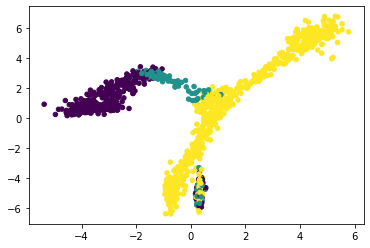

In [575]:
ax = pylab.subplot(111)
# ax.scatter(embedding1[:, 0], embedding1[:, 1], 20, timepoint1)
ax.scatter(embedding2[:, 0], embedding2[:, 1], 20, timepoint2)
qqqq = ax.figure.show()

In [576]:
u1 = pca(embedding1, no_dims=2)


Preprocessing the data using PCA...


<ipython-input-577-6aa3bb320aed>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax.figure.show()


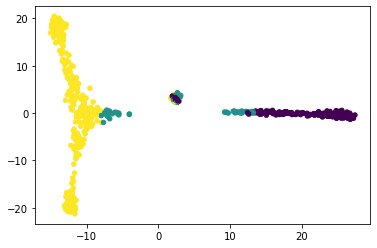

In [577]:
ax = pylab.subplot(111)
ax.scatter(u1[:, 0], u1[:, 1], 20, timepoint1)
ax.figure.show()

In [578]:
u2 = pca(embedding2, no_dims=2)

Preprocessing the data using PCA...


<ipython-input-579-2c4047d2ce4c>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax.figure.show()


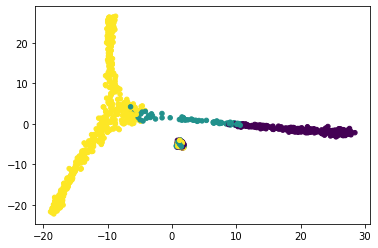

In [579]:
ax = pylab.subplot(111)
ax.scatter(u2[:, 0], u2[:, 1], 20, timepoint2)
ax.figure.show()

In [552]:
tf_embed1 = tf.Variable(u1, dtype=tf.float32)
tf_embed2 = tf.Variable(u2, dtype=tf.float32)

with tf.GradientTape(persistent=True) as tape:
    res = maximum_mean_discrepancy(tf_embed1, tf_embed2, bandwidth=10.0)

k = 100000
[dx1, dx2] = tape.gradient(res, [tf_embed1, tf_embed2])
new_u1 = u1 + k*dx1.numpy()
new_u2 = u2 + k*dx2.numpy()

In [553]:
dx1.numpy()

array([[ 4.0437132e-07, -4.0391315e-05],
       [-1.4063280e-05, -8.9992627e-06],
       [ 4.2588119e-05,  3.3816050e-06],
       ...,
       [ 1.2750204e-05, -1.4739365e-05],
       [ 1.6505815e-05, -1.6283593e-07],
       [-2.4650684e-05,  7.2605890e-06]], dtype=float32)

In [554]:
# ax = pylab.subplot(111)
# ax.scatter(dx1.numpy()[:, 0], dx1.numpy()[:, 1], 20, timepoint1)
# ax.scatter(dx2.numpy()[:, 0], dx2.numpy()[:, 1], 20, timepoint2)
# qqqq = ax.figure.show()

<ipython-input-555-dc8ad0fb5f39>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  qqqq = ax.figure.show()


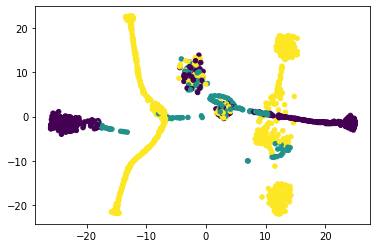

In [555]:
ax = pylab.subplot(111)
ax.scatter(new_u1[:, 0], new_u1[:, 1], 20, timepoint1)
ax.scatter(new_u2[:, 0], new_u2[:, 1], 20, timepoint2)
qqqq = ax.figure.show()

<ipython-input-551-484c669a319d>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  qqqq = ax.figure.show()


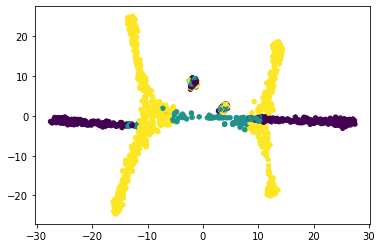

In [551]:
ax = pylab.subplot(111)
ax.scatter(u1[:, 0], u1[:, 1], 20, timepoint1)
ax.scatter(u2[:, 0], u2[:, 1], 20, timepoint2)
qqqq = ax.figure.show()

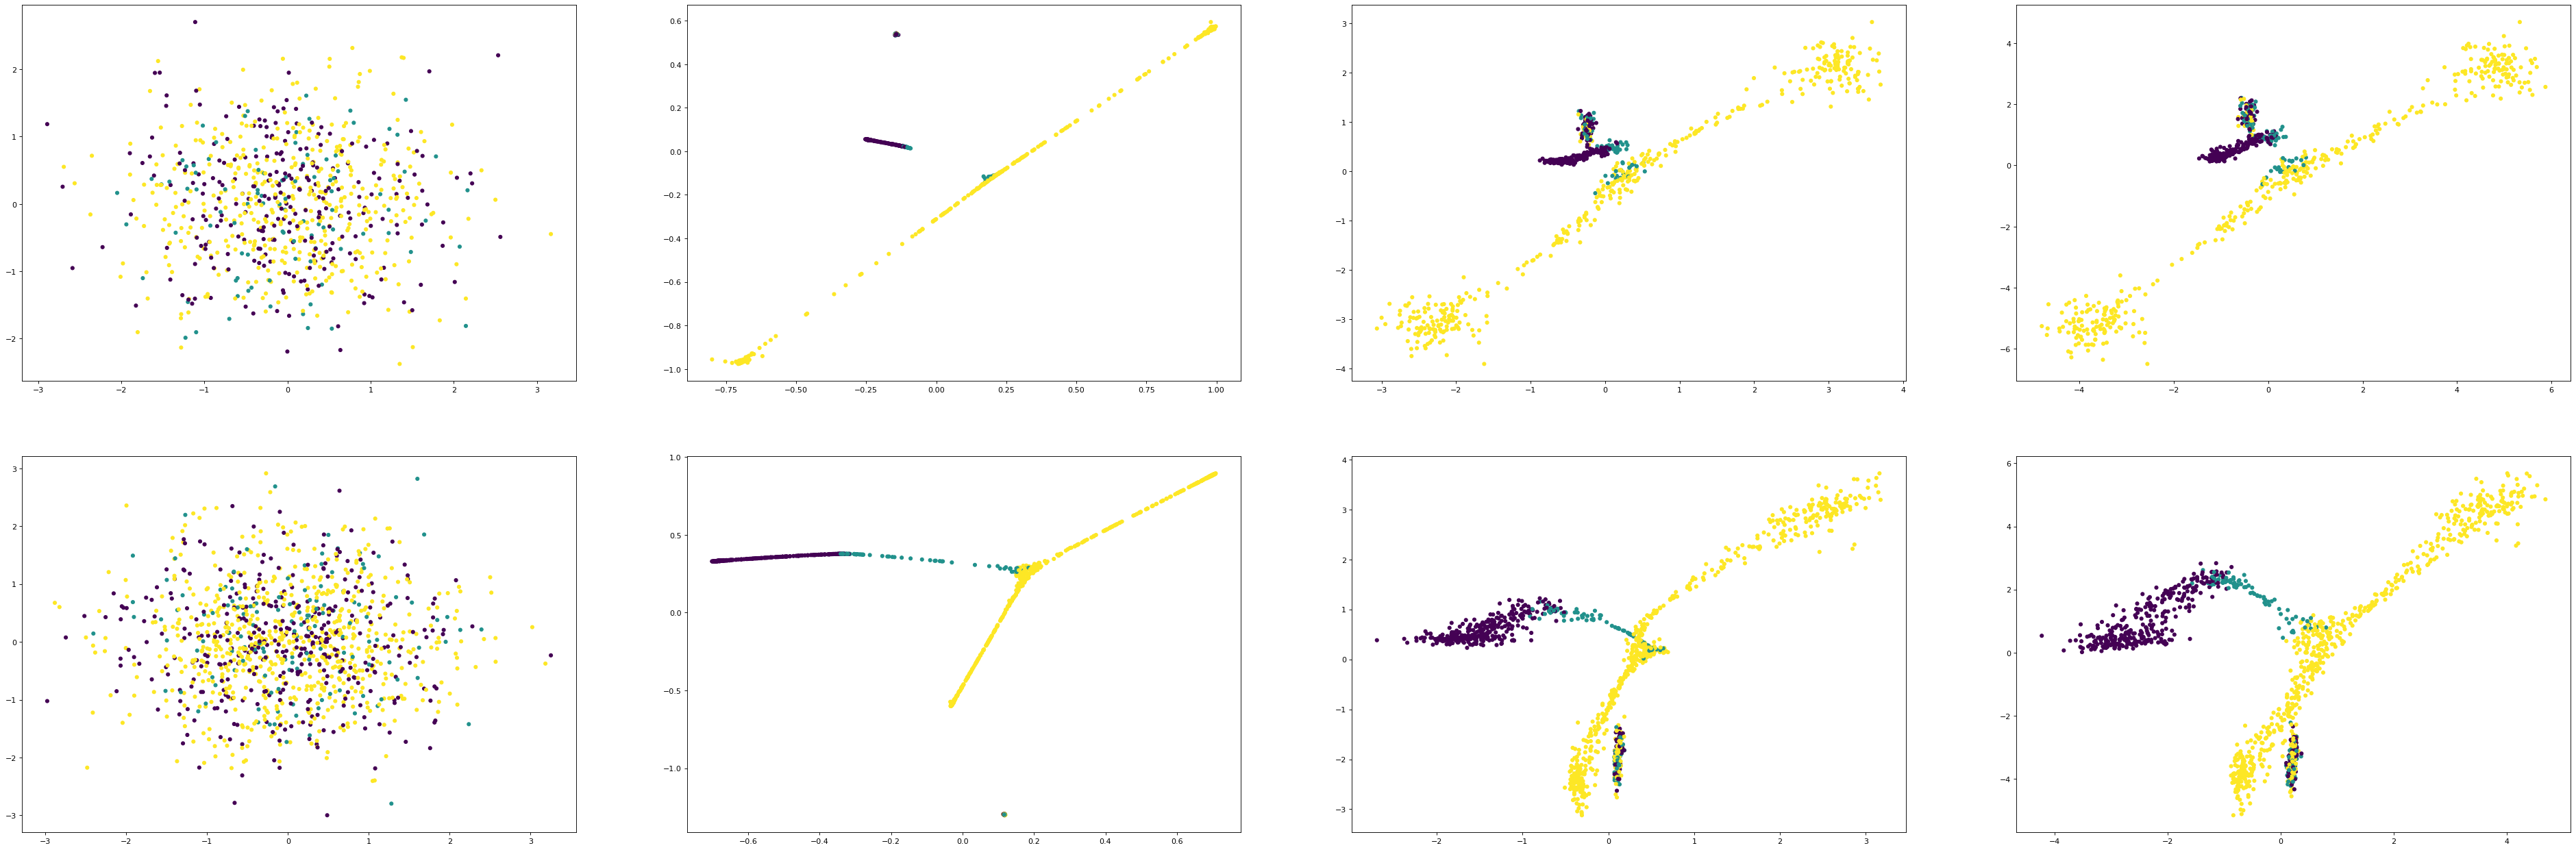

In [410]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(60, 20), dpi=80)  # create a plot figure

k = 75
n_plots = 4
for i in range(n_plots):
    
    plt.subplot(2, n_plots, i+1) # (rows, columns, panel number)
    plt.scatter(ts1.embeddings_after_mmd[i*k+1][:, 0], ts1.embeddings_after_mmd[i*k+1][:, 1], 20, timepoint1)
    plt.subplot(2, n_plots, i+1+n_plots) # (rows, columns, panel number)
    plt.scatter(ts2.embeddings_after_mmd[i*k+1][:, 0], ts2.embeddings_after_mmd[i*k+1][:, 1], 20, timepoint2)



ValueError: 'c' argument has 800 elements, which is inconsistent with 'x' and 'y' with size 1200.

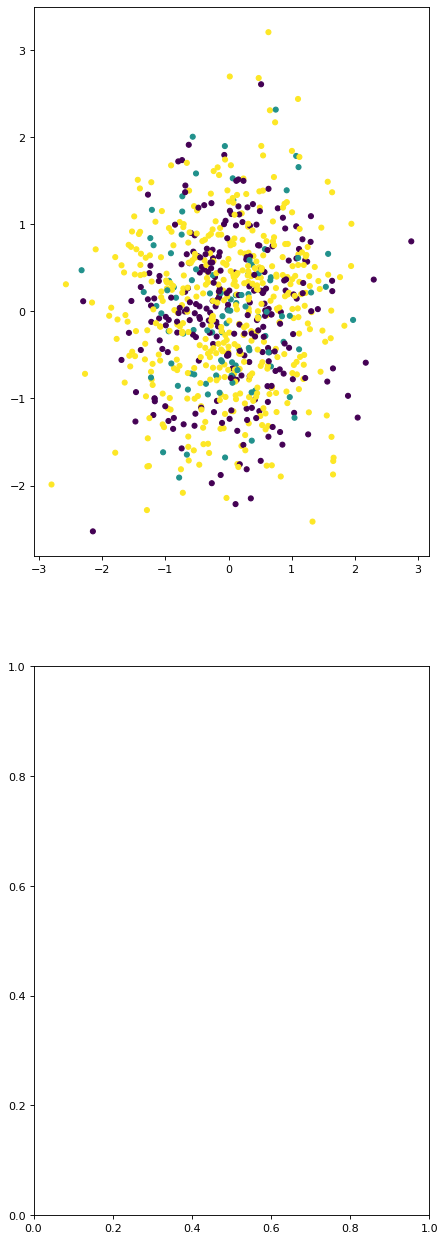

In [381]:
plt.figure(figsize=(60, 20), dpi=80)  # create a plot figure

k = 35
n_plots = 8
for i in range(n_plots):
    
    plt.subplot(2, n_plots, i+1) # (rows, columns, panel number)
    plt.scatter(ts1.embeddings_before_mmd[i*k+1][:, 0], ts1.embeddings_after_mmd[i*k+1][:, 1], 20, timepoint1)
    plt.subplot(2, n_plots, i+1+n_plots) # (rows, columns, panel number)
    plt.scatter(ts2.embeddings_before_mmd[i*k+1][:, 0], ts2.embeddings_after_mmd[i*k+1][:, 1], 20, timepoint1)




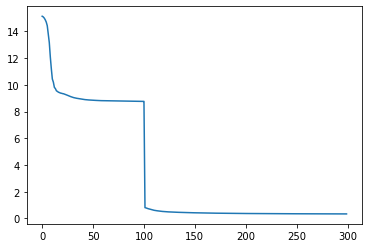

In [364]:
plt.plot(ts1.ce_loss);

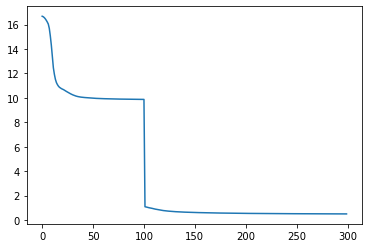

In [365]:
plt.plot(ts2.ce_loss);

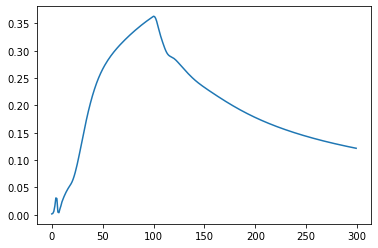

In [366]:
plt.plot(ts2.mmd_loss);

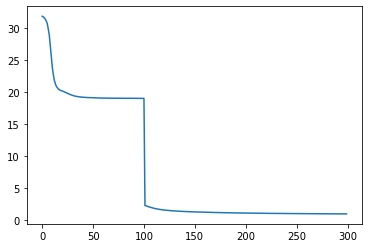

In [367]:
plt.plot((np.array([ts1.mmd_loss]) + np.array([ts1.ce_loss]) + np.array([ts2.ce_loss])).reshape(-1));

In [782]:
proximities = [2**(i-10) for i in range(20)]
for i in range(len(proximities)):
    new_embedding1, new_embedding2, mmd_loss = mmd(ts1.Y, ts2.Y, proximity=proximities[i], ratio=10000)
    print(proximities[i], mmd_loss)

0.0009765625 0.013067420799122376
0.001953125 0.03449521901269814
0.00390625 0.06908906137708348
0.0078125 0.10314049239164413
0.015625 0.1279235018005161
0.03125 0.14249702211129375
0.0625 0.13834194056911325
0.125 0.11683701372665738
0.25 0.0879953310066105
0.5 0.06012861847018709
1 0.037851868202047195
2 0.022482971007033715
4 0.013101832625130922
8 0.007916975242308338
16 0.0052191977364908
32 0.0038446224125591984
64 0.0031589583327378654
128 0.002833551710951802
256 0.002683757397840066
512 0.002610132745535685


In [783]:
new_embedding1, new_embedding2, mmd_loss = mmd(ts1.Y, ts2.Y, proximity=1, ratio=10000)

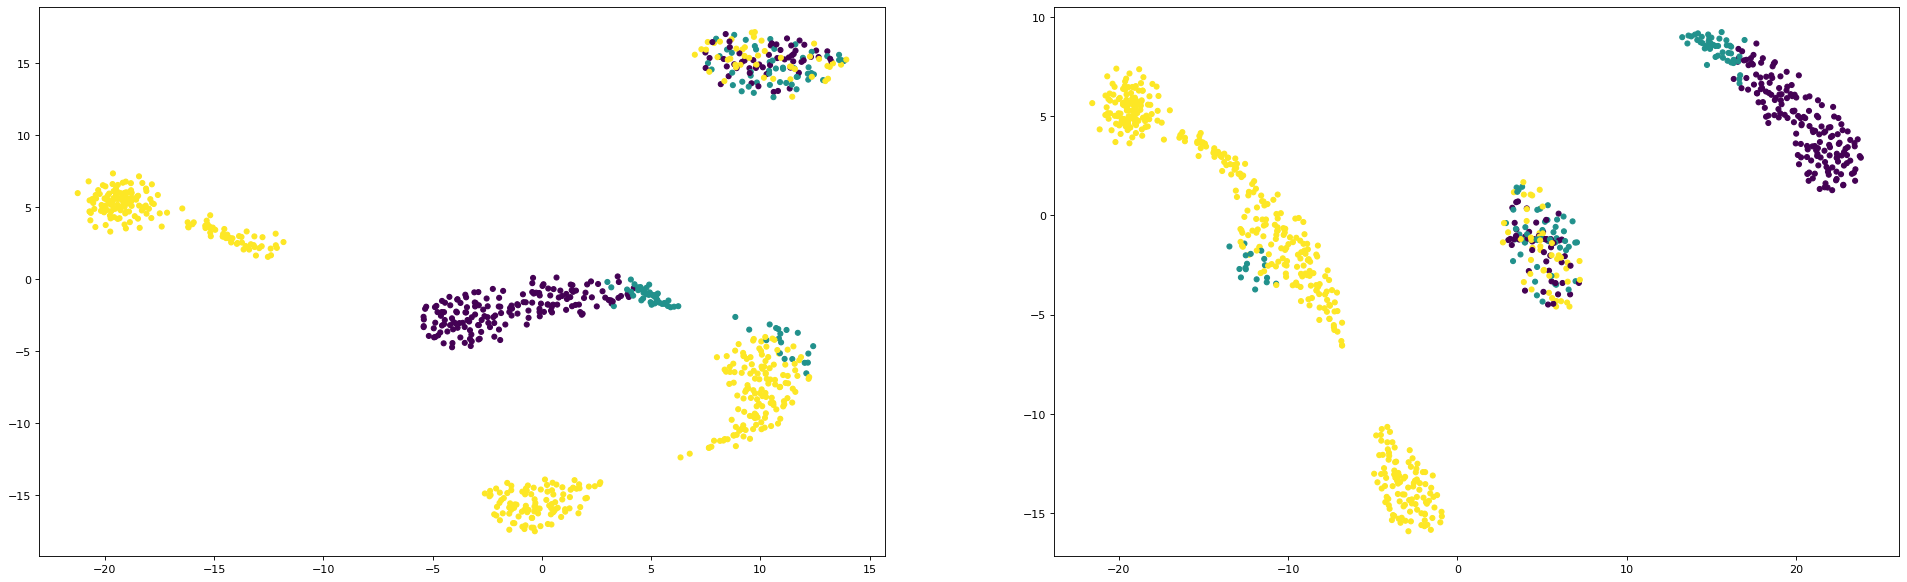

In [784]:
plt.figure(figsize=(30, 20), dpi=80)  # create a plot figure

plt.subplot(2, 2, 1) # (rows, columns, panel number)
plt.scatter(new_embedding1[:, 0], new_embedding1[:, 1], 20, timepoint1)
plt.subplot(2, 2, 2) # (rows, columns, panel number)
plt.scatter(new_embedding2[:, 0], new_embedding2[:, 1], 20, timepoint1)